In [1]:
%matplotlib inline

http://alleninstitute.github.io/AllenSDK/_static/examples/nb/mouse_connectivity.html

In [2]:
import pandas as pd
import numpy as np
import nibabel as nb
from nighres.io import io_mesh
import matplotlib.pyplot as plt
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

### Import template and annotation file and save to nifti

In [3]:
mcc = MouseConnectivityCache(manifest_file=
                             '/home/julia/data/gradients/atlas/allen_api/mouse_connectivity_manifest.json')

In [4]:
template, template_info = mcc.get_template_volume('/home/julia/data/gradients/atlas/allen_api/template.nrrd')
annot, annot_info = mcc.get_annotation_volume('/home/julia/data/gradients/atlas/allen_api/annotation.nrrd')

2020-02-29 12:47:54,740 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/annotation_25.nrrd


In [6]:
nb.Nifti1Image(annot, np.eye(4)*0.025).to_filename('/home/julia/data/gradients/atlas/allen_api/annotation.nii.gz')
nb.Nifti1Image(template, np.eye(4)*0.025).to_filename('/home/julia/data/gradients/atlas/allen_api/annotation/template.nii.gz')

### Access information from structure tree

In [14]:
structure_tree = mcc.get_structure_tree()
structure_tree.get_name_map()

{997: 'root',
 8: 'Basic cell groups and regions',
 567: 'Cerebrum',
 688: 'Cerebral cortex',
 695: 'Cortical plate',
 315: 'Isocortex',
 184: 'Frontal pole, cerebral cortex',
 68: 'Frontal pole, layer 1',
 667: 'Frontal pole, layer 2/3',
 526157192: 'Frontal pole, layer 5',
 526157196: 'Frontal pole, layer 6a',
 526322264: 'Frontal pole, layer 6b',
 500: 'Somatomotor areas',
 107: 'Somatomotor areas, Layer 1',
 219: 'Somatomotor areas, Layer 2/3',
 299: 'Somatomotor areas, Layer 5',
 644: 'Somatomotor areas, Layer 6a',
 947: 'Somatomotor areas, Layer 6b',
 985: 'Primary motor area',
 320: 'Primary motor area, Layer 1',
 943: 'Primary motor area, Layer 2/3',
 648: 'Primary motor area, Layer 5',
 844: 'Primary motor area, Layer 6a',
 882: 'Primary motor area, Layer 6b',
 993: 'Secondary motor area',
 656: 'Secondary motor area, layer 1',
 962: 'Secondary motor area, layer 2/3',
 767: 'Secondary motor area, layer 5',
 1021: 'Secondary motor area, layer 6a',
 1085: 'Secondary motor area, 

### Download and save masks and meshes for brain, isocortex, piriform cortex and hippocampus

In [15]:
structures = structure_tree.get_structures_by_name(['Isocortex', 'root', 'Hippocampal region', 'Piriform area'])
pd.DataFrame(structures)

,acronym,graph_id,graph_order,id,name,structure_id_path,structure_set_ids,rgb_triplet
0,Isocortex,1,5,315,Isocortex,"[997, 8, 567, 688, 695, 315]","[2, 112905828, 691663206, 12, 184527634, 11290...","[112, 255, 113]"
1,root,1,0,997,root,[997],[691663206],"[255, 255, 255]"
2,HIP,1,455,1080,Hippocampal region,"[997, 8, 567, 688, 695, 1089, 1080]","[112905828, 691663206, 12, 184527634, 11290581...","[126, 208, 75]"
3,PIR,1,416,961,Piriform area,"[997, 8, 567, 688, 695, 698, 961]","[112905828, 691663206, 688152358, 687527945, 1...","[106, 203, 186]"


In [22]:
cortex_mask, cm_info = mcc.get_structure_mask(315, '/home/julia/data/gradients/atlas/allen_api/cortex.nrrd')
root_mask, root_info = mcc.get_structure_mask(997, '/home/julia/data/gradients/atlas/allen_api/brain.nrrd')

In [ ]:
nb.Nifti1Image(cortex_mask, np.eye(4)).to_filename('/home/julia/data/gradients/atlas/allen_api/cortex.nii.gz')
nb.Nifti1Image(root_mask, np.eye(4)).to_filename('/home/julia/data/gradients/atlas/allen_api/brain.nii.gz')

In [ ]:
cortex_mesh=mcc.get_structure_mesh(315, '/home/julia/data/gradients/atlas/allen_api/cortex_mesh.obj')
root_mesh=mcc.get_structure_mesh(997, '/home/julia/data/gradients/atlas/allen_api/brain_mesh.obj')

In [ ]:
io_mesh.save_mesh_geometry('/home/julia/data/gradients/atlas/allen_api/cortex_mesh.vtk',
                           {"points":cortex_mesh[0], "faces":cortex_mesh[2]})
io_mesh.save_mesh_geometry('/home/julia/data/gradients/atlas/allen_api/brain_mesh.vtk',
                           {"points":root_mesh[0], "faces":root_mesh[2]})

In [5]:
hpc_mesh = mcc.get_structure_mesh(1080, '/home/julia/data/gradients/atlas/allen_api/hpc_mesh.obj')
piri_mesh = mcc.get_structure_mesh(961, '/home/julia/data/gradients/atlas/allen_api/piri_mesh.obj')

2020-02-27 17:25:03,725 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_meshes/1080.obj
2020-02-27 17:25:07,743 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_meshes/961.obj


### Make masks for individual layers of isocortex

In [17]:
iso_structs = structure_tree.descendants([315])[0]

In [18]:
l1 = []
l2_3 = []
l4 = []
l5 = []
l6a = []
l6b = []
lx = []

for i in range(len(iso_structs)):
    if 'layer 1' in iso_structs[i]['name'].lower():
        l1.append(iso_structs[i])
    elif 'layer 2/3' in iso_structs[i]['name'].lower():
        l2_3.append(iso_structs[i])
    elif 'layer 2' in iso_structs[i]['name'].lower():
        l2_3.append(iso_structs[i])
    elif 'layer 4' in iso_structs[i]['name'].lower():
        l4.append(iso_structs[i])
    elif 'layer 5' in iso_structs[i]['name'].lower():
        l5.append(iso_structs[i])
    elif 'layer 6a' in iso_structs[i]['name'].lower():
        l6a.append(iso_structs[i])
    elif 'layer 6b' in iso_structs[i]['name'].lower():
        l6b.append(iso_structs[i])
    else:
        lx.append(iso_structs[i])            

In [20]:
layers = ['l1', 'l2_3', 'l4', 'l5', 'l6a', 'l6b']
layer_lists = [l1, l2_3, l4, l5, l6a, l6b]
layer_plot = np.zeros_like(template)

for l in range(len(layers)):
    layer_mask = np.zeros_like(template)
    for m in layer_lists[l]:
        try:
            layer_mask += mcc.get_structure_mask(m['id'])[0]
        except:
            pass
    layer_plot[layer_mask==1] = (l+1)*10
    nb.Nifti1Image(layer_mask, np.eye(4)*0.025).to_filename(
        '/home/julia/data/gradients/atlas/allen_api/layers/%s.nii.gz' %layers[l])

2020-02-29 12:58:30,758 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_107.nrrd
2020-02-29 12:58:31,072 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /home/julia/data/gradients/atlas/allen_api/annotation/ccf_2017/structure_masks/resolution_25/structure_107.nrrd from http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_107.nrrd (request).
2020-02-29 12:58:31,074 allensdk.api.api.retrieve_file_over_http ERROR    We weren't able to download a structure mask for structure {0}. 
                                             You can instead build the mask locally using 
                                             ReferenceSpace.many_structure_masks
2020-02-29 12:58:31,519 allensdk.api.api.retrieve_file_over_htt

2020-02-29 12:58:41,461 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_480149290.nrrd
2020-02-29 12:58:41,777 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /home/julia/data/gradients/atlas/allen_api/annotation/ccf_2017/structure_masks/resolution_25/structure_480149290.nrrd from http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_480149290.nrrd (request).
2020-02-29 12:58:41,780 allensdk.api.api.retrieve_file_over_http ERROR    We weren't able to download a structure mask for structure {0}. 
                                             You can instead build the mask locally using 
                                             ReferenceSpace.many_structure_masks
2020-02-29 12:58:41,783 allensdk.api.api.retr

2020-02-29 12:58:50,755 allensdk.api.api.retrieve_file_over_http ERROR    We weren't able to download a structure mask for structure {0}. 
                                             You can instead build the mask locally using 
                                             ReferenceSpace.many_structure_masks
2020-02-29 12:58:52,544 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_1053.nrrd
2020-02-29 12:58:52,860 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /home/julia/data/gradients/atlas/allen_api/annotation/ccf_2017/structure_masks/resolution_25/structure_1053.nrrd from http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_1053.nrrd (request).
2020-02-29 12:58:52,862 allensdk.api.api.retrieve_file_over_

2020-02-29 12:58:58,147 allensdk.api.api.retrieve_file_over_http ERROR    We weren't able to download a structure mask for structure {0}. 
                                             You can instead build the mask locally using 
                                             ReferenceSpace.many_structure_masks
2020-02-29 12:58:58,374 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_241.nrrd
2020-02-29 12:58:58,690 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /home/julia/data/gradients/atlas/allen_api/annotation/ccf_2017/structure_masks/resolution_25/structure_241.nrrd from http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_241.nrrd (request).
2020-02-29 12:58:58,692 allensdk.api.api.retrieve_file_over_htt

2020-02-29 12:59:08,234 allensdk.api.api.retrieve_file_over_http ERROR    We weren't able to download a structure mask for structure {0}. 
                                             You can instead build the mask locally using 
                                             ReferenceSpace.many_structure_masks
2020-02-29 12:59:08,462 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_635.nrrd
2020-02-29 12:59:08,775 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /home/julia/data/gradients/atlas/allen_api/annotation/ccf_2017/structure_masks/resolution_25/structure_635.nrrd from http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_635.nrrd (request).
2020-02-29 12:59:08,777 allensdk.api.api.retrieve_file_over_htt

2020-02-29 12:59:19,477 allensdk.api.api.retrieve_file_over_http ERROR    We weren't able to download a structure mask for structure {0}. 
                                             You can instead build the mask locally using 
                                             ReferenceSpace.many_structure_masks
2020-02-29 12:59:21,043 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_480149274.nrrd
2020-02-29 12:59:21,356 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /home/julia/data/gradients/atlas/allen_api/annotation/ccf_2017/structure_masks/resolution_25/structure_480149274.nrrd from http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_480149274.nrrd (request).
2020-02-29 12:59:21,359 allensdk.api.api.retr

2020-02-29 12:59:29,725 allensdk.api.api.retrieve_file_over_http ERROR    We weren't able to download a structure mask for structure {0}. 
                                             You can instead build the mask locally using 
                                             ReferenceSpace.many_structure_masks
2020-02-29 12:59:30,402 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_457.nrrd
2020-02-29 12:59:30,717 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /home/julia/data/gradients/atlas/allen_api/annotation/ccf_2017/structure_masks/resolution_25/structure_457.nrrd from http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_457.nrrd (request).
2020-02-29 12:59:30,719 allensdk.api.api.retrieve_file_over_htt

2020-02-29 12:59:40,631 allensdk.api.api.retrieve_file_over_http ERROR    We weren't able to download a structure mask for structure {0}. 
                                             You can instead build the mask locally using 
                                             ReferenceSpace.many_structure_masks
2020-02-29 12:59:40,633 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_719.nrrd
2020-02-29 12:59:40,952 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /home/julia/data/gradients/atlas/allen_api/annotation/ccf_2017/structure_masks/resolution_25/structure_719.nrrd from http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_719.nrrd (request).
2020-02-29 12:59:40,954 allensdk.api.api.retrieve_file_over_htt

2020-02-29 12:59:50,731 allensdk.api.api.retrieve_file_over_http ERROR    We weren't able to download a structure mask for structure {0}. 
                                             You can instead build the mask locally using 
                                             ReferenceSpace.many_structure_masks
2020-02-29 12:59:51,185 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_340.nrrd
2020-02-29 12:59:51,500 allensdk.api.api.retrieve_file_over_http ERROR    Couldn't retrieve file /home/julia/data/gradients/atlas/allen_api/annotation/ccf_2017/structure_masks/resolution_25/structure_340.nrrd from http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_340.nrrd (request).
2020-02-29 12:59:51,502 allensdk.api.api.retrieve_file_over_htt

### Plot volumes

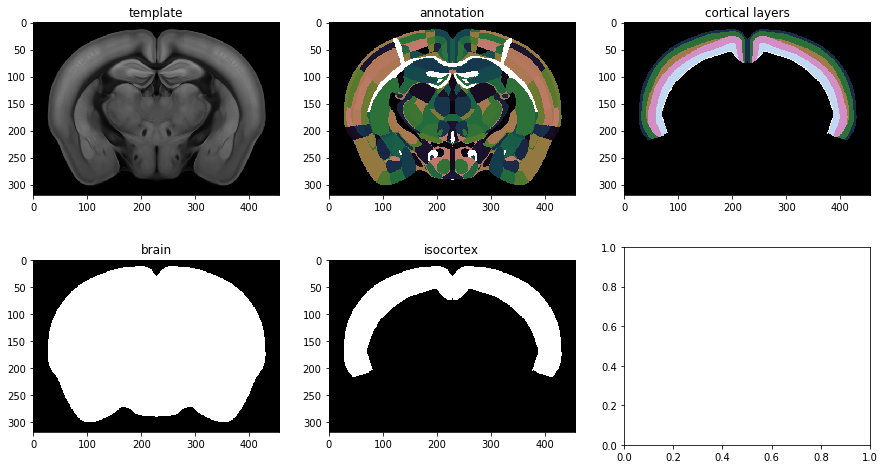

In [23]:
slice_idx = 264
f, ccf_axes = plt.subplots(2, 3, figsize=(15, 8))
ccf_axes[0,0].imshow(template[slice_idx,:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
ccf_axes[0,0].set_title("template")
ccf_axes[0,1].imshow(annot[slice_idx,:,:], cmap='cubehelix', aspect='equal', vmin=0, vmax=2000)
ccf_axes[0,1].set_title("annotation")
ccf_axes[0,2].imshow(layer_plot[slice_idx,:,:], cmap='cubehelix', aspect='equal')
ccf_axes[0,2].set_title("cortical layers")
ccf_axes[1,0].imshow(root_mask[slice_idx,:,:], cmap='gray', aspect='equal', vmin=0, vmax=1)
ccf_axes[1,0].set_title("brain")
ccf_axes[1,1].imshow(cortex_mask[slice_idx,:,:], cmap='gray', aspect='equal', vmin=0, vmax=1)
ccf_axes[1,1].set_title("isocortex")
plt.show()

### Fix hole in layer 6 (had mask for this hole in jo space) and save layers and mask

In [4]:
def jo2allen_vol(data):
    data = np.swapaxes(np.swapaxes(data, 0,1), 1,2)
    data = np.flip(np.flip(data,1),0)
    return data

missing_piece = nb.load('/home/julia/data/gradients/atlas/allen_api/layers/missing_piece_cortex_25um.nii.gz').get_data()
missing_piece_allen = jo2allen_vol(missing_piece)

l6a = nb.load('/home/julia/data/gradients/atlas/allen_api/layers/l6a.nii.gz')
nb.save(l6a,'/home/julia/data/gradients/atlas/allen_api/layers/l6a_orig.nii.gz')

l6a_fixed = np.zeros_like(l6a.get_data())
l6a_fixed[l6a.get_data()==1]=1
l6a_fixed[missing_piece_allen==1]=1
nb.save(nb.Nifti1Image(l6a_fixed, l6a.affine),'/home/julia/data/gradients/atlas/allen_api/layersl6a.nii.gz')

In [7]:
layers = ['l1', 'l2_3', 'l4', 'l5', 'l6a', 'l6b']
template = nb.load('/home/julia/data/gradients/atlas/allen_api/template.nii.gz')
layer_plot = np.zeros_like(template.get_data())

for l in range(len(layers)):
    layer = nb.load('/home/julia/data/gradients/atlas/allen_api/layers/%s.nii.gz' %layers[l]).get_data()
    layer_plot[layer==1] = (l+1)
nb.save(nb.Nifti1Image(layer_plot, template.affine, template.header), 
        '/home/julia/data/gradients/atlas/allen_api/layers/all_layers.nii.gz')

In [13]:
cortex = np.zeros_like(layer_plot)
cortex[layer_plot!=0]=1
aff=np.eye(4)*0.025
aff[3,3]=1
nb.save(nb.Nifti1Image(cortex, aff), 
        '/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight.nii.gz')